In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from skimage.io import imread
from skimage.transform import resize
from os.path import join
from glob import glob
import cv2
from skimage.feature import hog, local_binary_pattern
from skimage import exposure
import matplotlib.pyplot as plt
from tqdm import tqdm
from xgboost import XGBClassifier
import seaborn as sns

# Setup

In [2]:
# Set the name of the main folder containing the four classes folders
main_folder = 'tom_and_jerry'

# Set the class ordening
order = [
    'tom_jerry_0',
    'tom_jerry_1',
    'tom',
    'jerry'
]

# Functions

In [3]:
def get_labels(name):
    if 'tom_jerry_0' in name:
        return 0
    elif 'tom_jerry_1' in name:
        return 1
    elif 'tom' in name:
        return 2
    elif 'jerry' in name:
        return 3
    else:
        raise NotImplementedError('Not existing class!')

In [4]:
def extract_features(images, feat_type, img_size):

    labels = []
    features = []

    for image in tqdm(images):

        image_name = image.split('\\')[1]
        label = get_labels(image_name)

        img = cv2.imread(image, 1)

        img = cv2.resize(img, (img_size, img_size))

        if feat_type == 'hog':
            feat = hog(img, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1))
        elif feat_type == 'lbp':
            feat = np.ravel(local_binary_pattern(img, P=100, R=5))
        elif feat_type == 'img':
            img = img / 256.0
            feat = np.ravel(img)
        else:
            raise NotImplementedError('Not implemented feature!')

        features.append(feat)
        labels.append(label)

    return np.array(features), np.array(labels)

In [5]:
def class_percentage(dataset, title, class_colors={'tom': 'red', 'jerry': 'green', 'tom_jerry_0': 'dodgerblue', 'tom_jerry_1': 'gold'}):
    class_counts = {}
    total_images = len(dataset)
    
    for path in dataset:
        class_name = path.split('\\')[1] 
        class_counts[class_name] = class_counts.get(class_name, 0) + 1
    
    labels = class_counts.keys()
    sizes = [count / total_images * 100 for count in class_counts.values()]

    colors = [class_colors[class_name] for class_name in labels]

    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
    plt.title(title)
    plt.axis('equal')
    plt.show()

# Data exploration & analysis

In [6]:
folders = ['jerry', 'tom', 'tom_jerry_0', 'tom_jerry_1']
for folder in folders:
    images = glob(join(main_folder, folder, '*.jpg'))
    print('Total amount of {}: {}'.format(folder, len(images)))

Total amount of jerry: 1240
Total amount of tom: 1930
Total amount of tom_jerry_0: 1528
Total amount of tom_jerry_1: 780


In [7]:
images = glob(join(main_folder, '*', '*.jpg'))
print('Total amount of images: {}'.format(len(images)))
print('List of images:', images)

Total amount of images: 5478
List of images: ['tom_and_jerry\\jerry\\frame100.jpg', 'tom_and_jerry\\jerry\\frame1032.jpg', 'tom_and_jerry\\jerry\\frame1033.jpg', 'tom_and_jerry\\jerry\\frame1034.jpg', 'tom_and_jerry\\jerry\\frame1035.jpg', 'tom_and_jerry\\jerry\\frame1036.jpg', 'tom_and_jerry\\jerry\\frame1037.jpg', 'tom_and_jerry\\jerry\\frame1038.jpg', 'tom_and_jerry\\jerry\\frame1039.jpg', 'tom_and_jerry\\jerry\\frame104.jpg', 'tom_and_jerry\\jerry\\frame1040.jpg', 'tom_and_jerry\\jerry\\frame1046.jpg', 'tom_and_jerry\\jerry\\frame105.jpg', 'tom_and_jerry\\jerry\\frame106.jpg', 'tom_and_jerry\\jerry\\frame1083.jpg', 'tom_and_jerry\\jerry\\frame1084.jpg', 'tom_and_jerry\\jerry\\frame1085.jpg', 'tom_and_jerry\\jerry\\frame1087.jpg', 'tom_and_jerry\\jerry\\frame1088.jpg', 'tom_and_jerry\\jerry\\frame1094.jpg', 'tom_and_jerry\\jerry\\frame1095.jpg', 'tom_and_jerry\\jerry\\frame1102.jpg', 'tom_and_jerry\\jerry\\frame1103.jpg', 'tom_and_jerry\\jerry\\frame1110.jpg', 'tom_and_jerry\\jerry\

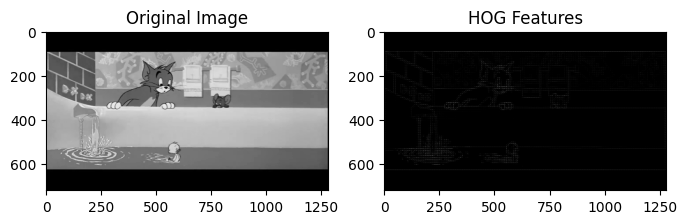

In [8]:
# Load the image
image = cv2.imread(images[5465])

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#resized_image = resize(gray_image, (224, 224))

# Calculate HOG features
hog_features, hog_image = hog(gray_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)

# Visualize the HOG image
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Features')
plt.show()

# Data preparation

In [9]:
print('Before shuffling: {}'.format(images[:10]))
np.random.shuffle(images)
print('After shuffling: {}'.format(images[:10]))

Before shuffling: ['tom_and_jerry\\jerry\\frame100.jpg', 'tom_and_jerry\\jerry\\frame1032.jpg', 'tom_and_jerry\\jerry\\frame1033.jpg', 'tom_and_jerry\\jerry\\frame1034.jpg', 'tom_and_jerry\\jerry\\frame1035.jpg', 'tom_and_jerry\\jerry\\frame1036.jpg', 'tom_and_jerry\\jerry\\frame1037.jpg', 'tom_and_jerry\\jerry\\frame1038.jpg', 'tom_and_jerry\\jerry\\frame1039.jpg', 'tom_and_jerry\\jerry\\frame104.jpg']
After shuffling: ['tom_and_jerry\\tom_jerry_0\\frame2528.jpg', 'tom_and_jerry\\tom\\frame4713.jpg', 'tom_and_jerry\\tom\\frame4144.jpg', 'tom_and_jerry\\tom_jerry_0\\frame4024.jpg', 'tom_and_jerry\\tom_jerry_0\\frame71.jpg', 'tom_and_jerry\\tom\\frame4501.jpg', 'tom_and_jerry\\jerry\\frame2908.jpg', 'tom_and_jerry\\tom\\frame2126.jpg', 'tom_and_jerry\\tom_jerry_1\\frame3780.jpg', 'tom_and_jerry\\tom\\frame1227.jpg']


In [10]:
trainset = images[:int(0.7*len(images))]
valset = images[int(0.7*len(images)):int(0.85*len(images))]
testset = images[int(0.85*len(images)):]
print('Total: {} splitted in Train: {}, Val: {} and Test: {}'.format(len(images), len(trainset), len(valset), len(testset)))

Total: 5478 splitted in Train: 3834, Val: 822 and Test: 822


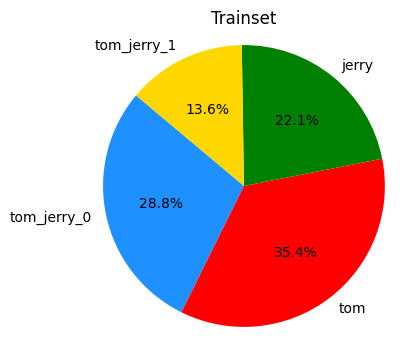

In [11]:
class_percentage(trainset, 'Trainset')

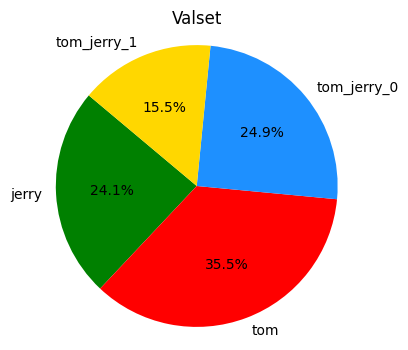

In [12]:
class_percentage(valset, 'Valset')

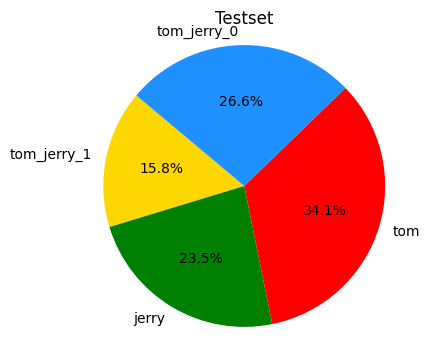

In [13]:
class_percentage(testset, 'Testset')

In [14]:
img_size = 120
feature_type = 'img'

train_x, train_y = extract_features(trainset, feature_type, img_size)
val_x, val_y = extract_features(valset, feature_type, img_size)
test_x, test_y = extract_features(testset, feature_type, img_size)
print('Train: {}, Val: {} and Test: {}'.format(len(train_x), len(val_x), len(test_x)))
print('Total: {}'.format(len(train_x) + len(val_x) + len(test_x)))

100%|██████████| 822/822 [00:05<00:00, 152.37it/s]


Train: 3834, Val: 822 and Test: 822
Total: 5478


# Modelling - Support Vector Classifier

### Training

In [16]:
clf = SVC(kernel='rbf', class_weight='balanced', decision_function_shape='ovo', random_state=42, probability=True)
clf.fit(train_x, train_y)

SVC(class_weight='balanced', decision_function_shape='ovo', probability=True,
    random_state=42)

### Validation

In [17]:
# Accuracy
print('Validation accuracy SVC: {:.3f}'.format(clf.score(val_x, val_y)))

Validation accuracy SVC: 0.556


In [18]:
# AUC score
pred_y_proba_val = clf.predict_proba(val_x)
print('Validation AUC score SVC: {}'.format(roc_auc_score(val_y, pred_y_proba_val, multi_class='ovo')))

Validation AUC score SVC: 0.7956625315610878


### Test

In [19]:
# Predictions
pred_y_train = clf.predict(train_x)
pred_y_test = clf.predict(test_x)

# Probabilities
pred_y_proba_train = clf.predict_proba(train_x)
pred_y_proba_test = clf.predict_proba(test_x)

#AUC score
auc_score_train = roc_auc_score(train_y, pred_y_proba_train, multi_class='ovo')
auc_score_test = roc_auc_score(test_y, pred_y_proba_test, multi_class='ovo')

In [20]:
# Predicted values against Ground Truth
print('Predicted {} samples: {}'.format(len(pred_y_test), pred_y_test))
print('GT {} samples: {}'.format(len(test_y), test_y))

Predicted 225 samples: [1 3 3 2 1 2 1 3 3 2 3 2 3 2 2 2 2 1 3 3 3 3 0 3 3 0 3 0 0 2 0 2 2 2 3 0 0
 3 0 3 1 2 3 2 3 2 0 0 0 3 3 0 3 1 0 1 2 2 3 3 2 2 2 2 2 2 2 2 3 2 2 0 0 0
 2 2 0 1 3 2 0 3 0 0 3 3 2 3 2 3 3 2 1 3 0 2 0 3 3 2 3 0 0 2 2 2 3 1 0 3 0
 2 2 0 1 0 2 2 3 0 2 3 3 1 3 3 0 2 2 0 0 1 3 2 2 3 0 3 0 1 0 1 1 0 0 2 0 2
 1 2 3 3 0 2 2 0 2 1 2 0 1 1 0 0 0 1 2 3 3 2 0 2 0 0 0 3 0 0 3 3 3 0 2 2 0
 0 3 2 0 2 3 1 1 2 3 0 0 0 3 0 1 0 1 2 3 0 3 0 0 1 2 2 0 1 0 0 0 3 2 3 3 2
 1 2 1]
GT 225 samples: [2 2 3 1 1 2 2 2 3 2 0 0 3 2 0 0 2 2 3 2 3 0 3 3 1 0 0 0 0 3 3 0 3 1 2 1 1
 3 3 0 2 2 2 2 0 2 2 3 0 0 2 3 3 1 2 1 0 2 0 0 2 2 2 2 3 2 1 2 3 0 2 0 2 0
 2 2 2 2 0 2 0 0 2 0 3 3 2 3 0 2 3 2 0 3 0 3 0 0 3 2 3 2 0 3 2 2 3 1 0 3 0
 0 2 0 1 2 2 2 3 0 0 2 3 0 0 0 2 2 0 2 0 2 3 2 2 3 0 2 0 1 0 1 0 3 0 1 0 2
 2 2 2 3 2 2 2 3 2 1 2 0 1 1 2 0 0 2 2 0 3 0 2 1 0 0 0 3 0 3 0 3 3 2 2 2 3
 0 3 2 3 2 3 1 0 0 3 2 3 0 3 2 1 2 1 2 0 2 3 0 1 1 2 2 3 1 3 0 2 3 2 0 3 0
 1 2 1]


### Performance

In [21]:
# Classification report
print('--------------SUPPORT VECTOR CLASSIFIER--------------')
print('----------------------TRAIN SET----------------------')
print(classification_report(train_y, pred_y_train))
print('AUC score:', auc_score_train)
print('----------------------TEST SET-----------------------')
print(classification_report(test_y, pred_y_test))
print('AUC score:', auc_score_test)


--------------SUPPORT VECTOR CLASSIFIER--------------
----------------------TRAIN SET----------------------
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       315
           1       0.82      0.88      0.85       144
           2       0.83      0.80      0.81       358
           3       0.70      0.84      0.77       233

    accuracy                           0.79      1050
   macro avg       0.79      0.80      0.79      1050
weighted avg       0.79      0.79      0.79      1050

AUC score: 0.9543642937278688
----------------------TEST SET-----------------------
              precision    recall  f1-score   support

           0       0.48      0.48      0.48        66
           1       0.59      0.65      0.62        26
           2       0.66      0.56      0.60        81
           3       0.55      0.65      0.60        52

    accuracy                           0.57       225
   macro avg       0.57      0.59      0.58    

### Confusion matrix

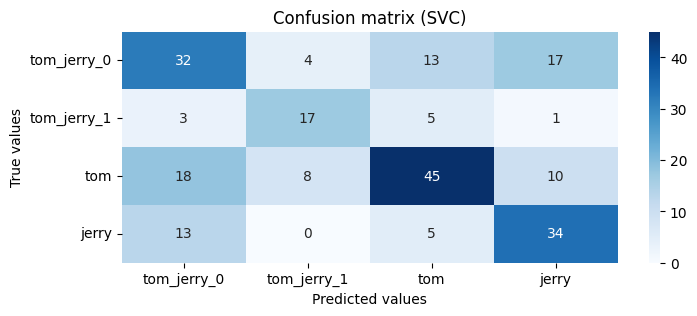

In [22]:
# Confusion matrix
conf_mat = confusion_matrix(test_y, pred_y_test)

# Plot confusion matrix
plt.figure(figsize=(8,3))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=order, yticklabels=order)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix (SVC)')
plt.show()

# Modelling - Decision Tree Classifier

### Training

In [16]:
clf = DecisionTreeClassifier(random_state=42)
clf.fit(train_x, train_y)

DecisionTreeClassifier(random_state=42)

### Validation

In [17]:
# Accuracy
print('Validation accuracy Decision Tree: {:.3f}'.format(clf.score(val_x, val_y)))

Validation accuracy Decision Tree: 0.651


In [18]:
# AUC score
pred_y_proba_val = clf.predict_proba(val_x)
print('Validation AUC score SVC: {}'.format(roc_auc_score(val_y, pred_y_proba_val, multi_class='ovo')))

Validation AUC score SVC: 0.7592918264635088


### Test

In [19]:
# Predictions
pred_y_train = clf.predict(train_x)
pred_y_test = clf.predict(test_x)

# Probabilities
pred_y_proba_train = clf.predict_proba(train_x)
pred_y_proba_test = clf.predict_proba(test_x)

#AUC score
auc_score_train = roc_auc_score(train_y, pred_y_proba_train, multi_class='ovo')
auc_score_test = roc_auc_score(test_y, pred_y_proba_test, multi_class='ovo')

In [20]:
# Predicted values against Ground Truth
print('Predicted {} samples: {}'.format(len(pred_y_test), pred_y_test))
print('GT {} samples: {}'.format(len(test_y), test_y))

Predicted 822 samples: [2 3 0 0 0 2 2 3 0 2 0 0 0 0 1 1 2 2 1 0 3 1 0 3 0 3 0 0 2 1 0 1 2 0 0 3 2
 1 3 2 2 0 0 1 2 2 0 2 3 2 1 3 2 2 2 2 0 2 1 3 0 0 0 1 1 0 1 1 0 3 2 1 0 2
 2 3 0 1 2 1 0 0 2 3 2 0 0 1 0 1 0 3 0 2 0 3 3 3 0 0 0 0 3 0 0 0 3 3 2 0 1
 1 0 2 0 2 0 0 3 0 3 3 2 2 2 0 1 1 0 1 3 2 0 2 1 2 0 2 0 1 3 3 3 0 2 2 3 3
 3 0 2 2 3 2 2 3 2 2 2 1 0 3 0 0 0 2 0 3 2 3 2 0 3 0 1 0 3 2 2 2 2 0 2 2 0
 0 3 2 1 2 2 2 2 1 2 1 0 0 0 2 3 0 0 2 2 0 0 3 3 1 2 3 0 1 2 1 1 0 0 3 0 2
 2 1 3 3 0 2 0 2 1 1 2 2 0 3 0 2 0 0 1 2 2 3 0 2 2 2 0 2 1 2 0 1 0 2 3 3 2
 2 3 0 2 3 3 3 0 1 2 1 3 2 2 3 0 0 3 2 2 3 3 2 3 3 0 2 1 0 2 2 2 0 3 2 2 0
 0 2 2 3 3 1 2 2 2 2 2 2 0 0 2 2 0 2 3 0 3 1 3 0 3 2 0 2 2 0 1 2 0 2 3 3 3
 0 1 2 1 0 2 0 2 2 3 3 3 3 0 2 3 0 2 0 0 3 0 1 3 0 0 0 2 3 0 2 2 0 2 0 3 0
 0 2 2 3 2 2 3 0 2 3 3 0 0 1 2 2 0 2 3 2 0 3 3 3 0 0 0 2 0 3 2 3 0 3 3 0 2
 2 0 3 0 0 3 2 0 0 3 3 1 2 3 0 3 2 0 3 2 1 2 3 0 2 0 2 2 3 0 2 2 2 3 0 3 0
 0 1 1 3 3 2 0 3 1 3 1 2 0 2 2 0 0 2 1 1 0 2 1 0 3 2 2 3 0 1 0 2 1 0 3 0 2
 3

### Performance

In [21]:
# Classification report
print('--------------DEECISION TREE CLASSIFIER--------------')
print('----------------------TRAIN SET----------------------')
print(classification_report(train_y, pred_y_train))
print('AUC score:', auc_score_train)
print('----------------------TEST SET-----------------------')
print(classification_report(test_y, pred_y_test))
print('AUC score:', auc_score_test)

--------------DEECISION TREE CLASSIFIER--------------
----------------------TRAIN SET----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1082
           1       1.00      1.00      1.00       559
           2       1.00      1.00      1.00      1355
           3       1.00      1.00      1.00       838

    accuracy                           1.00      3834
   macro avg       1.00      1.00      1.00      3834
weighted avg       1.00      1.00      1.00      3834

AUC score: 1.0
----------------------TEST SET-----------------------
              precision    recall  f1-score   support

           0       0.54      0.59      0.56       226
           1       0.58      0.59      0.59       106
           2       0.72      0.68      0.70       294
           3       0.63      0.61      0.62       196

    accuracy                           0.63       822
   macro avg       0.62      0.62      0.62       822
weighted

### Confusion matrix

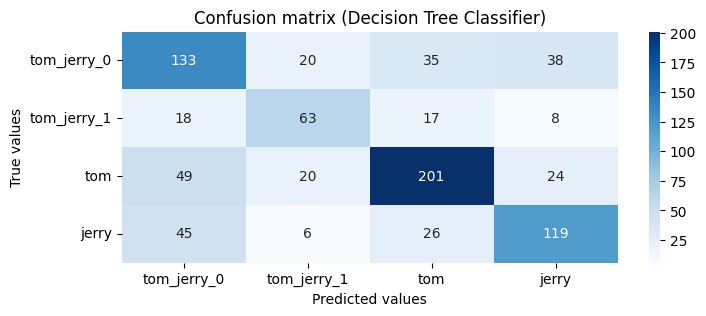

In [22]:
# Confusion matrix
conf_mat = confusion_matrix(test_y, pred_y_test)

# Plot confusion matrix
plt.figure(figsize=(8,3))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=order, yticklabels=order)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix (Decision Tree Classifier)')
plt.show()

# Modelling - Random Forest Classifier

### Training

In [23]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf.fit(train_x, train_y)

RandomForestClassifier(n_jobs=-1, random_state=42)

### Validation

In [24]:
# Accuracy
print('Validation accuracy RandomForest: {:.3f}'.format(clf.score(val_x, val_y)))

Validation accuracy RandomForest: 0.800


In [25]:
# AUC score
pred_y_proba_val = clf.predict_proba(val_x)
print('Validation AUC score SVC: {}'.format(roc_auc_score(val_y, pred_y_proba_val, multi_class='ovo')))

Validation AUC score SVC: 0.945907351454772


### Test

In [26]:
# Predictions
pred_y_train = clf.predict(train_x)
pred_y_test = clf.predict(test_x)

# Probabilities
pred_y_proba_train = clf.predict_proba(train_x)
pred_y_proba_test = clf.predict_proba(test_x)

#AUC score
auc_score_train = roc_auc_score(train_y, pred_y_proba_train, multi_class='ovo')
auc_score_test = roc_auc_score(test_y, pred_y_proba_test, multi_class='ovo')

In [27]:
# Predicted values against Ground Truth
print('Predicted {} samples: {}'.format(len(pred_y_test), pred_y_test))
print('GT {} samples: {}'.format(len(test_y), test_y))

Predicted 822 samples: [2 0 0 0 3 2 2 0 0 2 0 0 0 0 1 1 2 2 0 3 3 1 3 0 0 0 3 0 2 1 0 1 2 2 2 3 2
 1 3 2 0 3 3 2 2 2 0 2 2 2 3 3 2 2 2 3 0 2 1 3 0 2 0 1 0 0 1 1 0 3 2 1 0 2
 2 3 0 2 2 1 0 2 2 1 2 2 3 0 2 1 2 3 0 2 0 2 3 3 3 2 2 3 3 1 0 2 3 3 0 0 1
 1 0 2 0 2 0 2 0 2 3 3 2 2 2 2 2 0 2 1 3 2 3 2 1 2 3 2 0 1 3 0 3 0 0 2 2 3
 3 0 2 2 3 2 2 3 2 2 2 1 3 0 0 0 0 2 0 3 2 3 2 0 3 0 1 0 3 2 2 2 2 0 2 0 0
 0 3 2 0 2 0 1 2 1 0 1 0 2 0 2 3 2 0 2 2 1 0 3 3 2 2 3 2 1 2 1 1 0 3 3 0 2
 2 1 3 0 0 2 0 2 0 1 2 2 2 0 0 2 0 3 0 2 2 3 0 2 2 2 0 2 2 2 0 3 0 2 2 3 3
 2 2 3 2 2 3 3 3 1 0 2 3 2 2 3 0 1 3 2 2 3 3 2 0 3 0 1 2 2 2 3 2 3 2 2 2 0
 0 2 2 3 2 2 2 2 2 2 2 2 0 0 2 2 0 2 0 1 3 2 3 0 3 2 2 2 2 3 1 3 0 2 0 3 3
 3 2 2 1 0 2 0 2 2 0 3 3 0 3 2 3 2 2 2 2 2 3 2 3 0 0 2 3 0 0 2 2 0 2 0 3 3
 0 2 2 3 0 2 0 0 2 2 3 0 0 1 2 0 0 2 0 2 3 2 3 3 0 2 0 2 0 3 3 3 3 3 3 0 3
 0 0 3 0 3 3 2 0 0 3 0 1 2 3 0 3 2 0 3 2 0 2 2 0 2 0 2 2 2 2 2 2 2 3 0 3 2
 0 0 0 3 3 2 0 3 1 3 2 2 2 2 2 0 3 2 1 1 3 2 2 2 3 2 0 0 0 1 3 0 0 0 0 0 2
 2

### Performance

In [28]:
# Classification report
print('--------------RANDOM FOREST CLASSIFIER---------------')
print('----------------------TRAIN SET----------------------')
print(classification_report(train_y, pred_y_train))
print('AUC score:', auc_score_train)
print('----------------------TEST SET-----------------------')
print(classification_report(test_y, pred_y_test))
print('AUC score:', auc_score_test)

--------------RANDOM FOREST CLASSIFIER---------------
----------------------TRAIN SET----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1082
           1       1.00      1.00      1.00       559
           2       1.00      1.00      1.00      1355
           3       1.00      1.00      1.00       838

    accuracy                           1.00      3834
   macro avg       1.00      1.00      1.00      3834
weighted avg       1.00      1.00      1.00      3834

AUC score: 1.0
----------------------TEST SET-----------------------
              precision    recall  f1-score   support

           0       0.74      0.74      0.74       226
           1       0.86      0.73      0.79       106
           2       0.79      0.86      0.82       294
           3       0.81      0.76      0.78       196

    accuracy                           0.79       822
   macro avg       0.80      0.77      0.78       822
weighted

### Confusion matrix

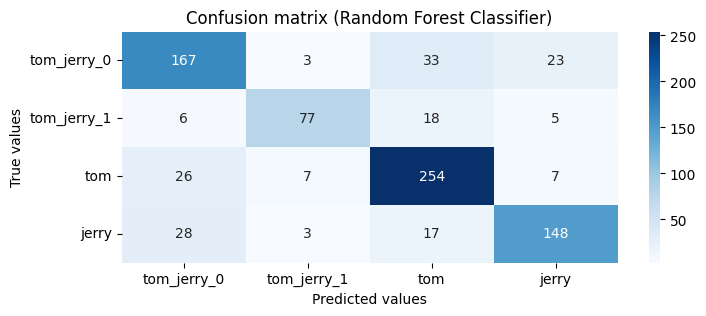

In [29]:
# Confusion matrix
conf_mat = confusion_matrix(test_y, pred_y_test)

# Plot confusion matrix
plt.figure(figsize=(8,3))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=order, yticklabels=order)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix (Random Forest Classifier)')
plt.show()

# Modelling - XGBoost Classifier

### Training

In [17]:
clf = XGBClassifier(random_state=42)
clf.fit(train_x, train_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

### Validation

In [18]:
# Accuracy
print('Validation accuracy XGBoost: {:.3f}'.format(clf.score(val_x, val_y)))

Validation accuracy XGBoost: 0.667


In [19]:
# AUC score
pred_y_proba_val = clf.predict_proba(val_x)
print('Validation AUC score SVC: {}'.format(roc_auc_score(val_y, pred_y_proba_val, multi_class='ovo')))

Validation AUC score SVC: 0.8757370557760854


### Test

In [20]:
# Predictions
pred_y_train = clf.predict(train_x)
pred_y_test = clf.predict(test_x)

# Probabilities
pred_y_proba_train = clf.predict_proba(train_x)
pred_y_proba_test = clf.predict_proba(test_x)

#AUC score
auc_score_train = roc_auc_score(train_y, pred_y_proba_train, multi_class='ovo')
auc_score_test = roc_auc_score(test_y, pred_y_proba_test, multi_class='ovo')

In [21]:
# Predicted values against Ground Truth
print('Predicted {} samples: {}'.format(len(pred_y_test), pred_y_test))
print('GT {} samples: {}'.format(len(test_y), test_y))

Predicted 225 samples: [2 3 3 3 0 2 3 0 1 0 0 2 3 2 1 0 2 2 2 0 0 3 0 1 3 3 3 0 2 0 0 3 3 0 0 0 0
 0 3 1 1 2 0 2 3 2 2 0 2 2 0 0 0 1 3 3 2 3 0 1 1 3 2 2 2 3 2 2 2 2 0 3 2 0
 0 0 2 2 2 2 1 0 2 2 3 2 0 3 1 3 2 3 2 0 3 2 0 0 3 2 0 0 3 3 0 1 0 2 3 3 3
 2 1 3 2 3 2 0 2 0 2 3 0 2 0 3 2 1 0 0 0 2 1 3 3 2 0 3 2 3 2 0 0 0 3 0 1 3
 3 0 0 0 3 0 2 0 2 0 3 3 0 0 1 0 2 3 2 2 0 2 2 1 0 3 2 0 2 2 3 2 2 0 0 2 0
 2 2 2 2 2 0 1 2 2 0 0 3 2 0 1 0 0 1 2 3 0 2 2 0 0 0 2 2 2 0 3 2 0 0 1 1 3
 2 2 3]
GT 225 samples: [2 0 2 3 2 0 3 0 1 0 0 2 3 0 1 2 2 2 2 0 0 3 0 1 3 3 3 2 2 3 2 3 3 0 2 0 2
 0 2 2 1 1 3 2 3 2 2 0 0 2 3 0 2 1 3 3 2 3 0 1 1 3 0 0 2 3 2 2 2 2 0 3 3 0
 2 0 1 2 2 2 0 0 2 2 3 2 1 3 1 2 0 3 2 2 3 2 0 0 0 2 0 2 2 0 1 1 0 0 3 3 3
 2 1 0 1 3 1 3 2 0 2 3 0 2 0 3 2 1 2 0 3 1 1 3 3 2 2 3 1 3 2 2 1 0 3 0 2 3
 0 2 3 0 3 0 2 0 2 0 3 2 0 2 1 0 0 3 2 2 0 2 2 1 0 3 2 0 2 2 3 0 2 0 0 2 3
 2 0 2 2 2 0 0 2 2 2 0 3 2 2 2 2 2 1 2 3 0 2 0 3 0 0 2 2 2 0 3 2 1 3 1 1 3
 3 2 3]


### Performance

In [22]:
# Classification report
print('------------------XGBOOST CLASSIFIER-----------------')
print('----------------------TRAIN SET----------------------')
print(classification_report(train_y, pred_y_train))
print('AUC score:', auc_score_train)
print('----------------------TEST SET-----------------------')
print(classification_report(test_y, pred_y_test))
print('AUC score:', auc_score_test)

------------------XGBOOST CLASSIFIER-----------------
----------------------TRAIN SET----------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       297
           1       1.00      1.00      1.00       165
           2       1.00      1.00      1.00       339
           3       1.00      1.00      1.00       249

    accuracy                           1.00      1050
   macro avg       1.00      1.00      1.00      1050
weighted avg       1.00      1.00      1.00      1050

AUC score: 1.0
----------------------TEST SET-----------------------
              precision    recall  f1-score   support

           0       0.57      0.70      0.63        61
           1       0.77      0.63      0.69        27
           2       0.75      0.68      0.71        84
           3       0.81      0.79      0.80        53

    accuracy                           0.71       225
   macro avg       0.73      0.70      0.71       225
weighted

### Confusion matrix

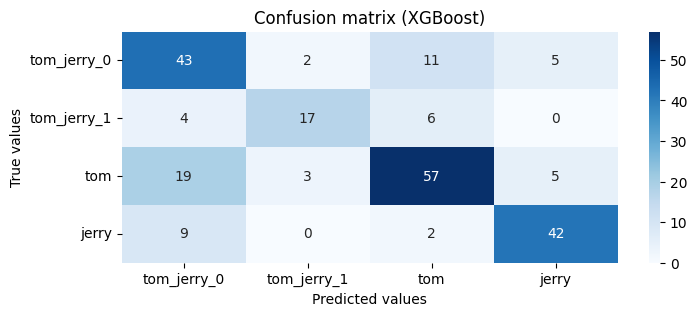

In [23]:
# Confusion matrix
conf_mat = confusion_matrix(test_y, pred_y_test)

# Plot confusion matrix
plt.figure(figsize=(8,3))
sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=order, yticklabels=order)
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix (XGBoost)')
plt.show()